# Materi 03: Segmentasi Citra
Segmentasi citra adalah proses membagi citra menjadi beberapa segmen untuk menyederhanakan representasinya agar lebih bermakna dan mudah dianalisis.

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# Fungsi unduh gambar sampel
def get_sample_image(url):
    res = requests.get(url)
    print(f"HTTP Status Code: {res.status_code}")
    print(f"Content-Type: {res.headers.get('Content-Type')}")

    if res.status_code != 200:
        print(f"Error: Could not retrieve image from {url}. Status code: {res.status_code}")
        return None

    try:
        img_pil = Image.open(BytesIO(res.content))
        return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"Error opening image with PIL: {e}")
        print("First 200 bytes of response content:")
        # Decode to utf-8 if possible, otherwise print raw bytes
        try:
            print(res.content[:200].decode('utf-8', errors='ignore'))
        except UnicodeDecodeError:
            print(res.content[:200])
        raise # Re-raise the original error after printing debug info

# Using a generic test image URL to ensure download function works
img_url = 'https://picsum.photos/seed/colab-test/800/600.jpg'
image = get_sample_image(img_url)
if image is not None:
    print('Setup Berhasil!')
else:
    print('Gagal setup: Tidak dapat memuat gambar.')

HTTP Status Code: 200
Content-Type: image/jpeg
Setup Berhasil!


## 1. Thresholding
Thresholding mengubah citra grayscale menjadi biner berdasarkan nilai ambang tertentu.

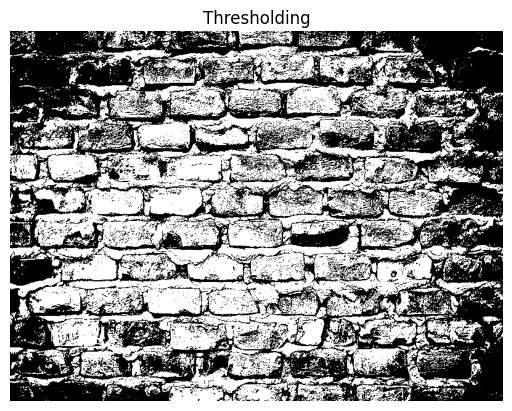

(<matplotlib.image.AxesImage at 0x7ebe27729760>,
 Text(0.5, 1.0, 'Thresholding'),
 (np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5)),
 None)

In [9]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

plt.imshow(thresh, cmap='gray'), plt.title('Thresholding'), plt.axis('off'), plt.show()

## 2. K-Means Clustering
Mengelompokkan piksel berdasarkan kemiripan warna atau intensitas menggunakan algoritma clustering.

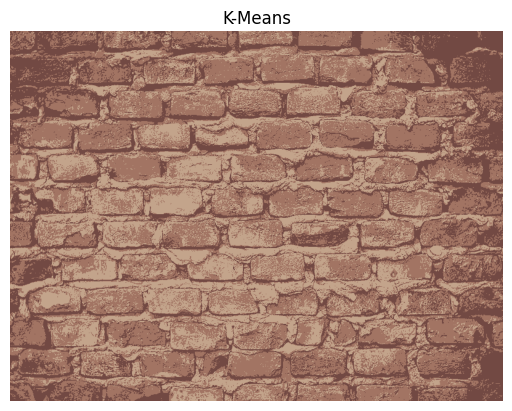

(<matplotlib.image.AxesImage at 0x7ebe27de6e70>,
 Text(0.5, 1.0, 'K-Means'),
 (np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5)),
 None)

In [10]:
Z = image.reshape((-1, 3))
Z = np.float32(Z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
res = centers[labels.flatten()].reshape(image.shape)

plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB)), plt.title('K-Means'), plt.axis('off'), plt.show()

## 3. Watershed Algorithm
Algoritma berbasis topologi yang memperlakukan intensitas citra seperti permukaan bumi (lembah dan bukit).

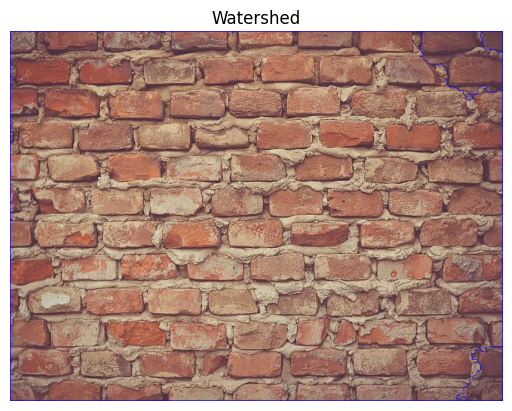

(<matplotlib.image.AxesImage at 0x7ebe1e5e55e0>,
 Text(0.5, 1.0, 'Watershed'),
 (np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5)),
 None)

In [11]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0]

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Watershed'), plt.axis('off'), plt.show()